# Semantic and instance segmentation of images
This shows an example of a combined approach to doing _semantic_ and _instance_ segmentation of images. For this example of microscope slides containing lice, this means segmenting the image such that each segment represents a unique object (an _instance_) and that that object is from a particular (_semantic_) class. In the case of these slides, the classes are: background, specimens, labels, barcodes, and type labels

In [1]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from segmentation.datasets import Slides, ImageFolder, SemiSupervisedDataLoader
from segmentation.instances import DiscriminativeLoss, mean_shift, visualise_embeddings, visualise_instances
from segmentation.network import SemanticInstanceSegmentation
from segmentation.training import train

/home/scman1/py_36_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define model
The model is a neural network with two heads: one for the semantic class embeddings, and one for the instance embedding. A discriminative loss function is used that encourages embeddings from the same instance to be closer to each other than to an embedding from any other instance

In [2]:
model = SemanticInstanceSegmentation()
instance_clustering = DiscriminativeLoss()

# Load data

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop((256, 768)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

target_transform = transforms.Compose([transform, transforms.Lambda(lambda x: (x * 255).long())])

batch_size = 3

# WARNING: Don't use multiple workers for loading! Doesn't work with setting random seed
train_data_labelled = Slides(download=True, train=True, root='data', transform=transform, target_transform=target_transform)
train_loader_labelled = torch.utils.data.DataLoader(train_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
train_loader_unlabelled = torch.utils.data.DataLoader(train_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_loader = SemiSupervisedDataLoader(train_loader_labelled, train_loader_unlabelled)

test_data_labelled = Slides(download=True, train=False, root='data', transform=transform, target_transform=target_transform)
test_loader_labelled = torch.utils.data.DataLoader(test_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
test_loader_unlabelled = torch.utils.data.DataLoader(test_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = SemiSupervisedDataLoader(test_loader_labelled, test_loader_unlabelled)

/home/scman1/semseg/segmentation/datasets.py:218: RuntimeWarning: divide by zero encountered in true_divide
  self.weights = torch.Tensor((1 / counts) / (1 / counts).sum())
/home/scman1/semseg/segmentation/datasets.py:218: RuntimeWarning: invalid value encountered in true_divide
  self.weights = torch.Tensor((1 / counts) / (1 / counts).sum())


# Train

In [4]:
train(model, instance_clustering, train_loader, test_loader)

/home/scman1/py_36_env/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Epoch:   1, Batch:   0, Loss: 61.979679107666016, Accuracy: 21.576944986979164%
Epoch:   1, Batch:   1, Loss: 54.03074264526367, Accuracy: 33.5113525390625%
Epoch:   1, Batch:   2, Loss: 51.66443634033203, Accuracy: 32.61515299479167%
Epoch:   1, Batch:   3, Loss: 55.07716751098633, Accuracy: 31.18896484375%
Epoch:   1, Batch:   4, Loss: 45.238372802734375, Accuracy: 28.58428955078125%
Epoch:   1, Batch:   5, Loss: 40.5397834777832, Accuracy: 45.15024820963542%
Epoch:   1, Batch:   6, Loss: 36.25299835205078, Accuracy: 66.0247802734375%
Epoch:   1, Batch:   7, Loss: 40.36897277832031, Accuracy: 43.58978271484375%
Epoch:  

Epoch:   5, Batch:  11, Loss: 24.341188430786133, Accuracy: 90.39255777994791%
Epoch:   5, Batch:  12, Loss: 21.181941986083984, Accuracy: 95.85520426432291%
Epoch:   5, Batch:  13, Loss: 22.482545852661133, Accuracy: 95.34047444661459%
Epoch:   5, Batch:  14, Loss: 23.8258113861084, Accuracy: 96.13087972005209%
Epoch:   5, Batch:  15, Loss: 21.60149574279785, Accuracy: 90.67026774088541%
Epoch:   5, Batch:  16, Loss: 22.14956283569336, Accuracy: 85.96649169921875%
Epoch:   5, Batch:  17, Loss: 21.82036781311035, Accuracy: 96.91162109375%
Epoch:   5, Batch:  18, Loss: 24.943458557128906, Accuracy: 92.66866048177084%
Epoch:   5, Batch:  19, Loss: 21.64472007751465, Accuracy: 93.7957763671875%
Epoch:   5, Batch:  20, Loss: 24.612552642822266, Accuracy: 87.066650390625%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch:   6, Batch:   0, Loss: 26.078819274902344, Accuracy: 94.79777018229166%
Epoch:   6, Batch:   1, Loss: 23.

Epoch:  10, Batch:   4, Loss: 18.072715759277344, Accuracy: 95.66294352213541%
Epoch:  10, Batch:   5, Loss: 16.35947608947754, Accuracy: 91.33758544921875%
Epoch:  10, Batch:   6, Loss: 14.838655471801758, Accuracy: 94.28151448567709%
Epoch:  10, Batch:   7, Loss: 17.938888549804688, Accuracy: 96.09171549479166%
Epoch:  10, Batch:   8, Loss: 17.787858963012695, Accuracy: 97.5982666015625%
Epoch:  10, Batch:   9, Loss: 17.615846633911133, Accuracy: 94.21590169270834%
Epoch:  10, Batch:  10, Loss: 17.259021759033203, Accuracy: 94.59431966145834%
Epoch:  10, Batch:  11, Loss: 18.623214721679688, Accuracy: 94.20623779296875%
Epoch:  10, Batch:  12, Loss: 15.277644157409668, Accuracy: 93.54095458984375%
Epoch:  10, Batch:  13, Loss: 16.699966430664062, Accuracy: 96.40401204427084%
Epoch:  10, Batch:  14, Loss: 18.388916015625, Accuracy: 96.63441975911459%
Epoch:  10, Batch:  15, Loss: 15.928051948547363, Accuracy: 89.99786376953125%
Epoch:  10, Batch:  16, Loss: 16.35033416748047, Accuracy

Epoch:  14, Batch:  20, Loss: 17.50441551208496, Accuracy: 93.55570475260416%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch:  15, Batch:   0, Loss: 18.674814224243164, Accuracy: 95.48187255859375%
Epoch:  15, Batch:   1, Loss: 17.13319969177246, Accuracy: 97.96142578125%
Epoch:  15, Batch:   2, Loss: 16.571697235107422, Accuracy: 97.84901936848959%
Epoch:  15, Batch:   3, Loss: 18.850276947021484, Accuracy: 97.00876871744791%
Epoch:  15, Batch:   4, Loss: 16.47782325744629, Accuracy: 96.95180257161459%
Epoch:  15, Batch:   5, Loss: 14.998525619506836, Accuracy: 91.12396240234375%
Epoch:  15, Batch:   6, Loss: 13.190483093261719, Accuracy: 96.40960693359375%
Epoch:  15, Batch:   7, Loss: 15.356171607971191, Accuracy: 96.92942301432291%
Epoch:  15, Batch:   8, Loss: 16.43140411376953, Accuracy: 97.53316243489584%
Epoch:  15, Batch:   9, Loss: 15.813423156738281, Accuracy: 96.37502034505209%
Epoch:  15, Batch:  10, Loss

Epoch:  19, Batch:  13, Loss: 15.27593994140625, Accuracy: 97.18475341796875%
Epoch:  19, Batch:  14, Loss: 16.375015258789062, Accuracy: 97.63031005859375%
Epoch:  19, Batch:  15, Loss: 14.305131912231445, Accuracy: 88.80513509114584%
Epoch:  19, Batch:  16, Loss: 14.586471557617188, Accuracy: 92.1539306640625%
Epoch:  19, Batch:  17, Loss: 14.982975006103516, Accuracy: 97.69795735677084%
Epoch:  19, Batch:  18, Loss: 16.853307723999023, Accuracy: 93.98244222005209%
Epoch:  19, Batch:  19, Loss: 15.57512378692627, Accuracy: 97.08099365234375%
Epoch:  19, Batch:  20, Loss: 16.782543182373047, Accuracy: 95.21382649739584%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch:  20, Batch:   0, Loss: 18.212738037109375, Accuracy: 96.09222412109375%
Epoch:  20, Batch:   1, Loss: 16.582359313964844, Accuracy: 97.75187174479166%
Epoch:  20, Batch:   2, Loss: 16.164283752441406, Accuracy: 97.82816569010416%
Epoch:  20, Batch:   3, 

Epoch:  24, Batch:   6, Loss: 12.256217956542969, Accuracy: 97.48484293619791%
Epoch:  24, Batch:   7, Loss: 15.942000389099121, Accuracy: 97.271728515625%
Epoch:  24, Batch:   8, Loss: 15.517500877380371, Accuracy: 97.28953043619791%
Epoch:  24, Batch:   9, Loss: 14.816688537597656, Accuracy: 97.23612467447916%
Epoch:  24, Batch:  10, Loss: 15.243288040161133, Accuracy: 96.68731689453125%
Epoch:  24, Batch:  11, Loss: 16.345142364501953, Accuracy: 95.65785725911459%
Epoch:  24, Batch:  12, Loss: 14.125296592712402, Accuracy: 97.09014892578125%
Epoch:  24, Batch:  13, Loss: 15.059648513793945, Accuracy: 97.42685953776041%
Epoch:  24, Batch:  14, Loss: 16.57349395751953, Accuracy: 97.77577718098959%
Epoch:  24, Batch:  15, Loss: 13.822300910949707, Accuracy: 89.70743815104166%
Epoch:  24, Batch:  16, Loss: 14.540473937988281, Accuracy: 91.93369547526041%
Epoch:  24, Batch:  17, Loss: 14.021556854248047, Accuracy: 98.29457600911459%
Epoch:  24, Batch:  18, Loss: 16.804977416992188, Accur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch:  29, Batch:   0, Loss: 18.06400489807129, Accuracy: 96.28194173177084%
Epoch:  29, Batch:   1, Loss: 16.201650619506836, Accuracy: 97.73152669270834%
Epoch:  29, Batch:   2, Loss: 15.889604568481445, Accuracy: 98.2208251953125%
Epoch:  29, Batch:   3, Loss: 17.998767852783203, Accuracy: 97.27325439453125%
Epoch:  29, Batch:   4, Loss: 15.095115661621094, Accuracy: 97.412109375%
Epoch:  29, Batch:   5, Loss: 13.591124534606934, Accuracy: 92.05169677734375%
Epoch:  29, Batch:   6, Loss: 12.342666625976562, Accuracy: 97.40498860677084%
Epoch:  29, Batch:   7, Loss: 15.926719665527344, Accuracy: 96.66290283203125%
Epoch:  29, Batch:   8, Loss: 14.417800903320312, Accuracy: 97.78544108072916%
Epoch:  29, Batch:   9, Loss: 14.976266860961914, Accuracy: 97.23459879557291%
Epoch:  29, Batch:  10, Loss: 15.252748489379883, Accuracy: 96.82820638020834%
Epoch:  29, Batch:  11, Loss

# Evaluate
Evaluates on test data, not on the training data

In [12]:
model.load_state_dict(torch.load('models/epoch_26'))
model.eval()

train_loader = torch.utils.data.DataLoader(test_data_labelled, batch_size=1, shuffle=True)

image, labels, instances = next(iter(train_loader))

image = Variable(image)
instances = Variable(instances + 1)
_, logits, instance_embeddings = model.forward_clean(image)

current_logits = logits[0]
current_labels = labels[0, 0]
current_instances = instances[0]

predicted_class = current_logits.data.max(0)[1]
predicted_instances = [None] * 5
for class_index in range(5):
    mask = predicted_class.view(-1) == class_index
    if mask.max() > 0:
        label_embedding = instance_embeddings[0].view(1, instance_embeddings.shape[1], -1)[..., mask]
        label_embedding = label_embedding.data.cpu().numpy()[0]

        predicted_instances[class_index] = mean_shift(label_embedding)

/home/scman1/py_36_env/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualise training results
Note that for _semantic_ segmentation the colours correspond to semantic classes, whereas for _instance_ segmentation the colours represent unique instances that can be in an arbitrary order - hence the ID number (colour) won't be the same as in the ground truth

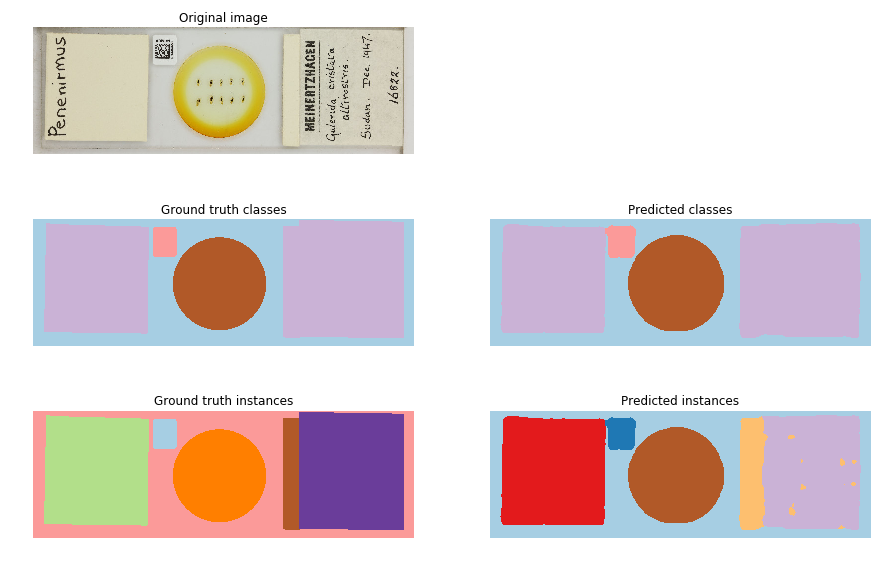

In [13]:
plt.rcParams['image.cmap'] = 'Paired'

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for ax in axes.flatten(): ax.axis('off')

axes[0, 0].set_title('Original image')
axes[0, 0].imshow(image[0].data.numpy().transpose(1, 2, 0))
axes[1, 0].set_title('Ground truth classes')
axes[1, 0].imshow(current_labels.cpu().numpy().squeeze())
axes[2, 0].set_title('Ground truth instances')
axes[2, 0].imshow(current_instances.cpu().numpy().squeeze())
axes[1, 1].set_title('Predicted classes')
axes[1, 1].imshow(predicted_class.cpu().numpy().squeeze())
instance_image = visualise_instances(predicted_instances, predicted_class, num_classes=5)
axes[2, 1].set_title('Predicted instances')
axes[2, 1].imshow(instance_image)

### Explicity clear memory on GPU
<small>Since all variables in the script are in the same scope, there is no garbage collection until reassignment. Need to get rid of derived data before running model subsequent times</small>

In [7]:
del (logits, instance_embeddings, instance_image, image, labels,
     instances, current_logits, current_labels, current_instances,
     mask, label_embedding, predicted_class, predicted_instances)

### Evaluate on full image
This evaluates on unlabelled data examples

In [8]:
filename = random.choice(list(Path('data', 'slides_subset').iterdir()))
image = torch.Tensor((plt.imread(filename) / 255).transpose(2, 0, 1)).unsqueeze(0)
_, logits, instance_embeddings = model.forward_clean(image)
predicted_class = logits[0].data.max(0)[1]
instance_embeddings = instance_embeddings[0]

predicted_instances = [None] * 5
for class_index in range(5):
    mask = predicted_class.view(-1) == class_index
    if mask.max() > 0:
       label_embedding = instance_embeddings.view(1, instance_embeddings.shape[0], -1)[..., mask]
       label_embedding = label_embedding.data.cpu().numpy()[0]

       predicted_instances[class_index] = mean_shift(label_embedding)

/home/scman1/py_36_env/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


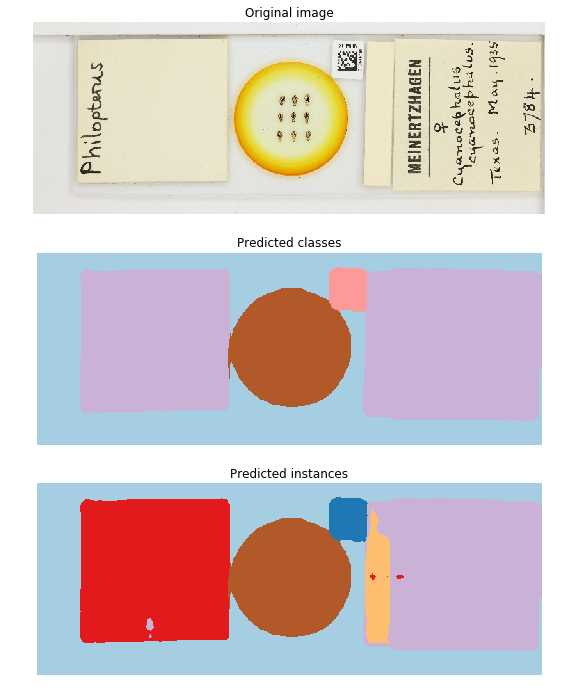

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for ax in axes: ax.axis('off')

axes[0].set_title('Original image')
axes[0].imshow(image[0].numpy().transpose(1, 2, 0))

axes[1].set_title('Predicted classes')
axes[1].imshow(predicted_class.cpu().numpy())

axes[2].set_title('Predicted instances')
axes[2].imshow(visualise_instances(predicted_instances, predicted_class, num_classes=5))